In [1]:
import pandas as pd
from jax import numpy as jnp
import kerax
from kerax import layers
from kerax.models import Model
import matplotlib.pyplot as plt
import jax
import numpy as np
import functools
from jax.nn.initializers import normal, glorot_normal
from jax.random import PRNGKey
from jax import lax
from jax import random
import optax

In [2]:
# MNIST training data
df = pd.read_csv('train.csv')
labels = df['label'].values
df.drop('label', axis=1, inplace=True)
imgs = df.values.reshape((df.shape[0],28, 28, 1)).astype('float32')
categorical_train_y = kerax.utils.to_categorical(labels, 10)

2022-04-13 04:00:21.487038: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
inputs1 = layers.Input(shape=(28, 28, 1))
conv1 = layers.Conv2D(64, 3, activation='relu')(inputs1)
maxpool1 = layers.MaxPooling2D(2)(conv1)
conv3 = layers.Conv2D(64, 3, activation='relu')(maxpool1)
maxpool3 = layers.MaxPooling2D(2)(conv3)
flatten = layers.Flatten()(maxpool3)
dense1 = layers.Dense(128, activation='relu')(flatten)
output1 = layers.Dense(10, activation='softmax')(dense1)

2022-04-13 04:30:50.378965: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
model = Model(inputs1, output1)

In [3]:
model = Model(inputs1, output1)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [4]:
model

In [16]:
model(np.random.random((1,28, 28, 1)))

DeviceArray([[0.11081819, 0.08797796, 0.10092622, 0.11795913, 0.09160063,
              0.10592711, 0.09290423, 0.09697939, 0.09485179, 0.10005528]],            dtype=float32)

In [28]:
class Fun:
    def __new__(cls, *args, **kwargs):
        print(args, kwargs)
        return kerax.engine.graph.GraphV2(*args, *kwargs)
    def __init__(self, x):
        self.x = x

In [29]:
Fun(inputs1, output1)

(<Input_2 Layer with input shape (28, 28, 1) and output shape (None, 28, 28, 1)>, <Dense_6 Layer with input shape (128,) and output shape (None, 10)>) {}


In [ ]:
model.fit(imgs, categorical_train_y, 1, 128)

Predicted: 1 Ground Truth: 1


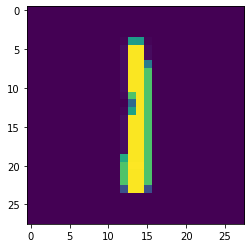

In [10]:
idx = 2
img = imgs[idx]
img = jnp.expand_dims(img, axis=0)
print('Predicted:', model(img).argmax(), 'Ground Truth:', labels[idx])
fig = plt.imshow(imgs[idx])